In [1]:
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from PIL import Image
# . split='train' picks which split to load
dataset = load_dataset(
    'mwalmsley/gz_evo', # each dataset has a random fixed train/test split
    split='train'
     # some datasets also allow name=subset (e.g. name="tiny" for gz_evo). see the viewer for subset options
) 
dataset.set_format('numpy')  # your framework of choice e.g. numpy, tensorflow, jax, etc
# print(dataset_name, dataset[0]['image'].shape)

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/30 [00:00<?, ?it/s]

In [6]:
unique_summaries = dataset.unique("summary")
unique_domains = dataset.unique("dataset_name")
print(f"Length of dataset: {len(dataset)}")
print(f"Number of unique summaries: {len(unique_summaries)}")
print(f"Number of unique domains: {len(unique_domains)}")
print(f"Unique summaries: {unique_summaries}")
print(f"Unique domains: {unique_domains}")
print(f"Image Size: {dataset[0]['image'].shape}")

Length of dataset: 664219
Number of unique summaries: 7
Number of unique domains: 5
Unique summaries: ['', 'smooth_round', 'smooth_cigar', 'unbarred_spiral', 'edge_on_disk', 'barred_spiral', 'featured_without_bar_or_spiral']
Unique domains: ['gz_desi', 'gz2', 'gz_hubble', 'gz_candels', 'gz_ukidss']
Image Size: (424, 424, 3)


In [27]:
## removing less confident labels
filtered_dataset = dataset.filter(lambda x: x['summary'] != '')
print(f"Length of filtered dataset: {len(filtered_dataset)}")

Length of filtered dataset: 239408


In [9]:
### split filtered datasets into subsets based on domain values
gz_desi = filtered_dataset.filter(lambda x: x['dataset_name'] == 'gz_desi')
print(f"Number of gz_desi images: {len(gz_desi)}")
gz2 = filtered_dataset.filter(lambda x: x['dataset_name'] == 'gz2')
print(f"Number of gz2 images: {len(gz2)}")
gz_hubble = filtered_dataset.filter(lambda x: x['dataset_name'] == 'gz_hubble')
print(f"Number of gz_hubble images: {len(gz_hubble)}")
gz_candels = filtered_dataset.filter(lambda x: x['dataset_name'] == 'gz_candels')
print(f"Number of gz_candels images: {len(gz_candels)}")
gz_ukidss = filtered_dataset.filter(lambda x: x['dataset_name'] == 'gz_ukidss')
print(f"Number of gz_ukidss images: {len(gz_ukidss)}")

Number of gz_desi images: 82185
Number of gz2 images: 95703
Number of gz_hubble images: 25027
Number of gz_candels images: 7863
Number of gz_ukidss images: 28630


In [11]:
from sklearn.model_selection import train_test_split
from collections import Counter

desi_labels = gz_desi["summary"]  # Extract labels
gz2_labels = gz2["summary"]
print(gz2_labels)
subset_size = 40000

# Perform stratified split
train_indices_desi, _ = train_test_split(
    range(len(desi_labels)),
    train_size=subset_size / len(desi_labels),
    stratify=desi_labels,
    random_state=42
)

train_indices_gz2, _ = train_test_split(
    range(len(gz2_labels)),
    train_size=subset_size / len(gz2_labels),
    stratify=gz2_labels,
    random_state=42
)
# Create the subset using indices
subset_desi = gz_desi.select(train_indices_desi)
subset_gz2 = gz2.select(train_indices_gz2)

['smooth_round' 'unbarred_spiral' 'unbarred_spiral' ... 'unbarred_spiral'
 'unbarred_spiral' 'smooth_cigar']


In [12]:
subset_desi_labels = subset_desi["summary"]
subset_gz2_labels = subset_gz2["summary"]

subset_desi_labels = np.array([unique_summaries.index(label) for label in subset_desi_labels])
subset_gz2_labels = np.array([unique_summaries.index(label) for label in subset_gz2_labels])

In [17]:
print(Counter(subset_desi_labels))

Counter({1: 19893, 3: 7340, 2: 5828, 4: 3680, 5: 2200, 6: 1059})


In [19]:
# Define a function to resize an image
def resize_image(example, size=(128, 128)):
    # Ensure the image array is of type uint8
    image_array = example['image'].astype(np.uint8)
    # Convert the NumPy array to a PIL Image
    image = Image.fromarray(image_array)
    # Resize the image
    image = image.resize(size)
    # Convert back to a NumPy array
    example['image'] = np.array(image)
    return example

# Apply the resizing transformation
resized_desi = subset_desi.map(lambda x: resize_image(x, size=(100, 100)), batched=False)
resized_gz2 = subset_gz2.map(lambda x: resize_image(x, size=(100, 100)), batched=False)

In [20]:
resized_images_desi = resized_desi["image"].astype(np.float64) / 255.0
resized_images_gz2 = resized_gz2["image"].astype(np.float64) / 255.0
labels_desi = resized_desi["summary"]
labels_gz2 = resized_gz2["summary"]

In [22]:
all_labels = np.unique(np.concatenate((labels_gz2, labels_desi), axis=0))

# Create a mapping dictionary
label_to_int = {label: idx for idx, label in enumerate(all_labels)}
print(label_to_int)

{'barred_spiral': 0, 'edge_on_disk': 1, 'featured_without_bar_or_spiral': 2, 'smooth_cigar': 3, 'smooth_round': 4, 'unbarred_spiral': 5}


In [23]:
y_gz = np.array([label_to_int[label] for label in labels_gz2])
y_desi = np.array([label_to_int[label] for label in labels_desi])

In [24]:
from sklearn.model_selection import train_test_split
x_train_gz, x_test_gz, y_train_gz, y_test_gz = train_test_split(resized_images_gz2, y_gz, test_size=0.2, random_state=42)
x_train_desi, x_test_desi, y_train_desi, y_test_desi = train_test_split(resized_images_desi, y_desi, test_size=0.2, random_state=42)

In [25]:
## isolate images from each class

class0_indices_desi = np.where(y_train_desi == 0)[0]
class1_indices_desi = np.where(y_train_desi == 1)[0]
class2_indices_desi = np.where(y_train_desi == 2)[0]
class3_indices_desi = np.where(y_train_desi == 3)[0]
class4_indices_desi = np.where(y_train_desi == 4)[0]
class5_indices_desi = np.where(y_train_desi == 5)[0]

class0_indices_gz = np.where(y_train_gz == 0)[0]
class1_indices_gz = np.where(y_train_gz == 1)[0]
class2_indices_gz = np.where(y_train_gz == 2)[0]
class3_indices_gz = np.where(y_train_gz == 3)[0]
class4_indices_gz = np.where(y_train_gz == 4)[0]
class5_indices_gz = np.where(y_train_gz == 5)[0]

117


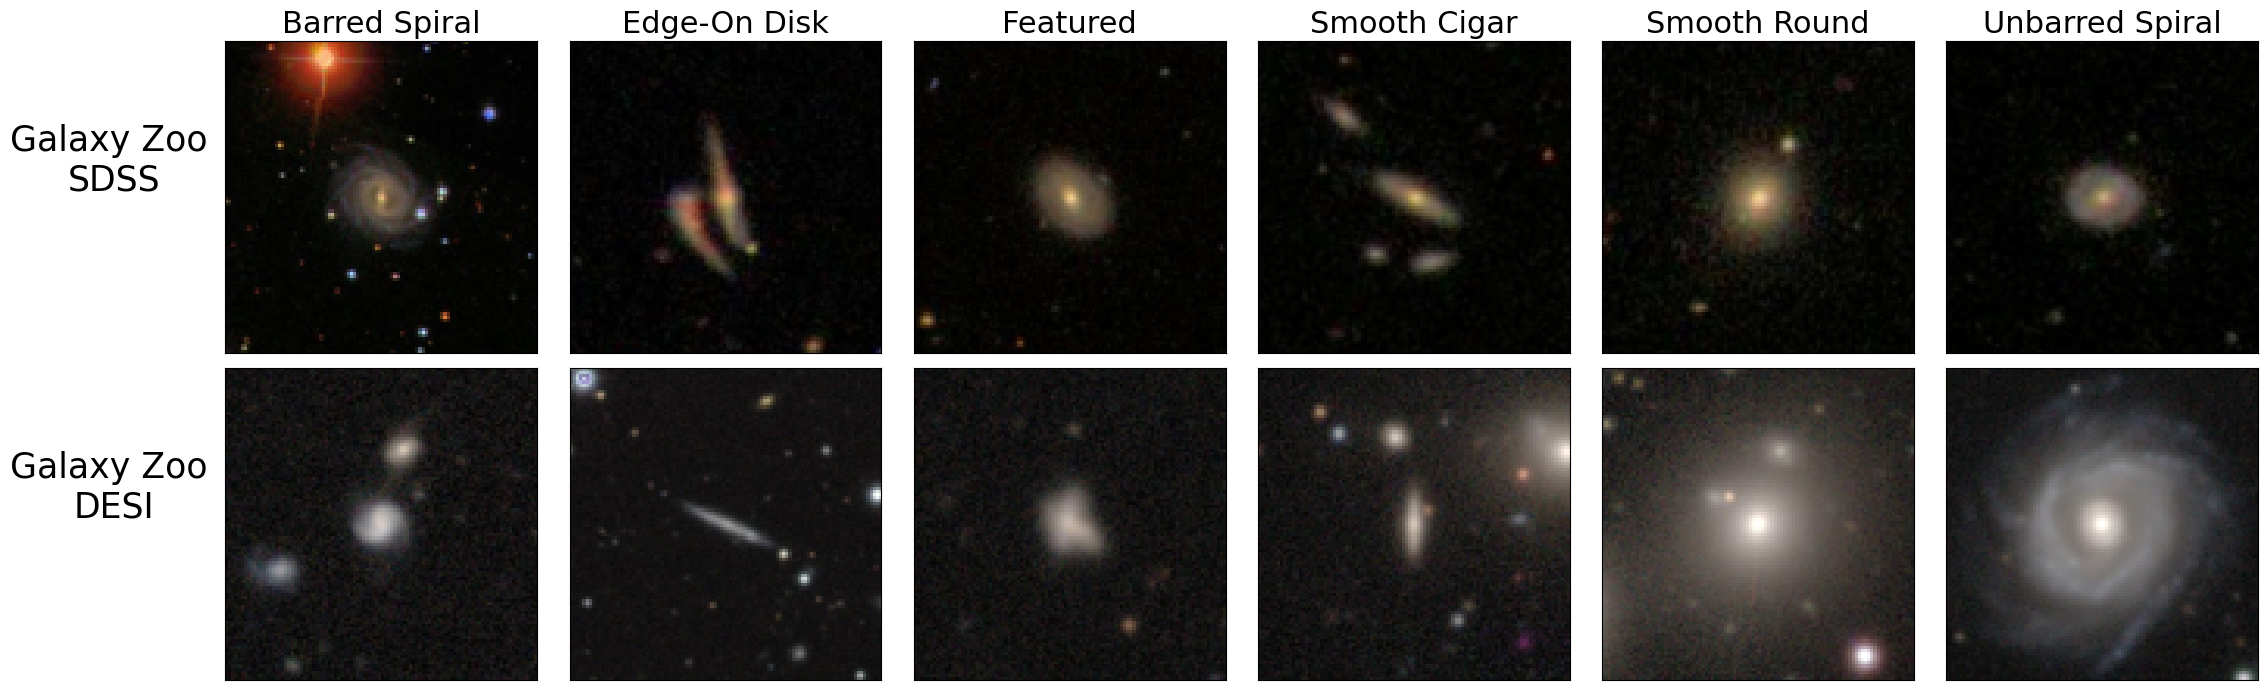

In [ ]:
idx = np.random.randint(0, min(len(class0_indices_desi), len(class1_indices_desi), len(class2_indices_desi), len(class3_indices_desi), len(class4_indices_desi), len(class5_indices_desi)))
print(idx)
idx = 485
fig, axs = plt.subplots(2, 6, figsize=(23, 7))

axs[0, 0].imshow(x_train_gz[class0_indices_gz[idx]])
axs[0,1].imshow(x_train_gz[class1_indices_gz[idx]])
axs[0,2].imshow(x_train_gz[class2_indices_gz[idx]])
axs[0,3].imshow(x_train_gz[class3_indices_gz[idx]])
axs[0,4].imshow(x_train_gz[class4_indices_gz[idx]])
axs[0,5].imshow(x_train_gz[class5_indices_gz[idx]])

axs[1, 0].imshow(x_train_desi[class0_indices_desi[idx]])
axs[1,1].imshow(x_train_desi[class1_indices_desi[idx]])
axs[1,2].imshow(x_train_desi[class2_indices_desi[idx]])
axs[1,3].imshow(x_train_desi[class3_indices_desi[idx]])
axs[1,4].imshow(x_train_desi[class4_indices_desi[idx]])
axs[1,5].imshow(x_train_desi[class5_indices_desi[idx]])
## remove all ticks
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

axs[0,0].set_ylabel('Galaxy Zoo \nSDSS', fontsize=25, rotation=0, labelpad=80)
axs[1,0].set_ylabel('Galaxy Zoo \nDESI', fontsize=25, rotation=0, labelpad=80)

axs[0,0].set_title('Barred Spiral', fontsize=22)
axs[0,1].set_title('Edge-On Disk', fontsize=22)
axs[0,2].set_title('Featured', fontsize=22)
axs[0,3].set_title('Smooth Cigar', fontsize=22)
axs[0,4].set_title('Smooth Round', fontsize=22)
axs[0,5].set_title('Unbarred Spiral', fontsize=22)

# plt.subplots_adjust(hspace=0.6)  # Increase this value as needed

plt.tight_layout()